In [20]:
#Goal of this task is to train the muliple layer nueral network , to inference on the handwritten letter and deciper the message
# for all the machine learning task we follow a simple frame work
# 1. Data ingestion
# 2. Data preparation
# 3. Model Building
# 4. Model Training
# 5. Model Evaluation
# 6. Model inference
# so lets start with imports first

In [21]:
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [54]:
#1. Data Ingestion
import sys

data_path = "/content/drive/MyDrive/Pytorch Certification/Part-1 Fundamentals/Image Classification MNIST"
download = True
if data_path not in sys.path:
    sys.path.append(data_path)
    download = True

#prepare transform to load the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.1736,0.3317)
])

#load the data to file and pytorch with transform
train_dataset = datasets.EMNIST(root=data_path,split='letters',train=True,download=download,transform=transform)
test_dataset = datasets.EMNIST(root=data_path,split='letters',train=False,download=download,transform=transform)

#prepare the dataloader
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size= 64,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size= 1000,shuffle=False)

In [55]:
import os
os.listdir(data_path)

['Decipher_Letter.ipynb',
 'helper_utils.py',
 '__pycache__',
 'MNIST',
 'Image_Classification_MNIST.ipynb',
 'emnist_helper.py',
 'EMNIST']

Size of train dataset:124800
Size of test dataset:20800
Shape of Train image:<built-in method size of Tensor object at 0x7e02b613cfa0>
Shape of Test image:<built-in method size of Tensor object at 0x7e02b5984230>


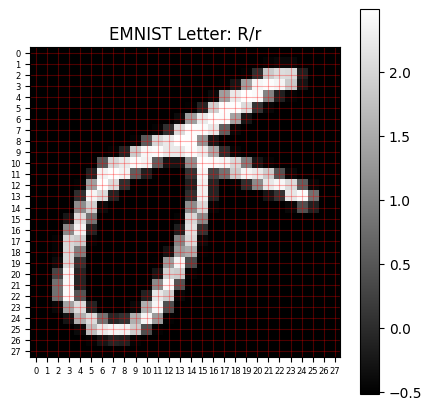

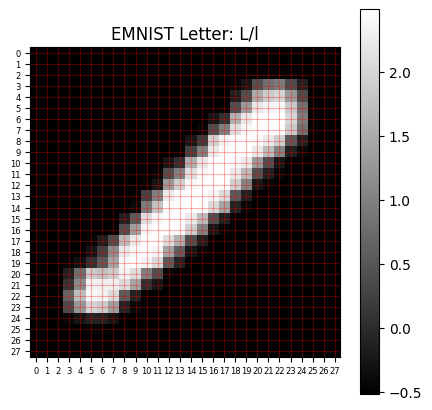

In [92]:
#2. Data preparation
# visualize the data
import emnist_helper as helper
import torchvision.transforms.functional as f

train_image, train_label = train_dataset[90000]
test_image, test_label = test_dataset[9000]

print(f"Size of train dataset:{len(train_dataset)}")
print(f"Size of test dataset:{len(test_dataset)}")
print(f"Shape of Train image:{train_image.size}")
print(f"Shape of Test image:{test_image.size}")

helper.visualize_image(train_image,train_label)
helper.visualize_image(test_image,test_label)

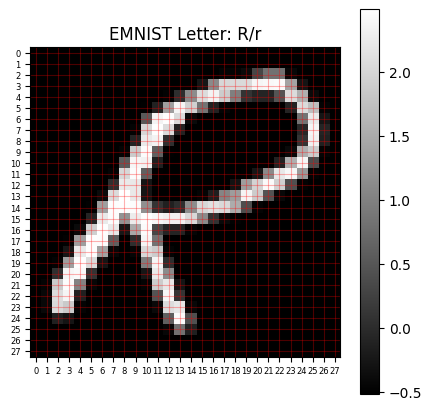

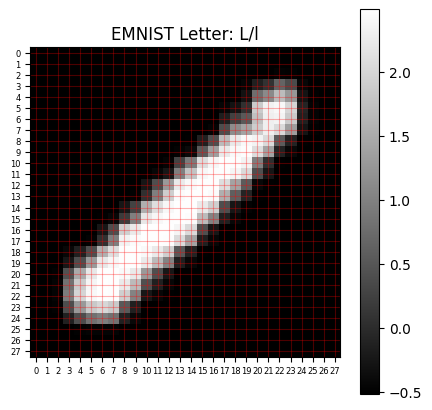

In [57]:
#visualize with 90 degree rotate
train_image = f.rotate(train_image,90)
test_image = f.rotate(test_image,90)
train_image = f.vflip(train_image)
test_image = f.vflip(test_image)


helper.visualize_image(train_image,train_label)
helper.visualize_image(test_image,test_label)

In [68]:
#3. Model Building
torch.manual_seed(42)

class EMNISTClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(784,512,bias=True),
        nn.ReLU(),
        nn.Linear(512,256,bias =True),
        nn.ReLU(),
        nn.Linear(256,26,bias=True)
    )
  def forward(self,x):
    x = self.flatten(x)
    x = self.layers(x)
    return x



In [80]:
def train_epoch(model,train_loader,loss_function,opt,device):
  #intializing parameters to track the loss and acc
  epoch_loss = 0.0
  batch_loss = 0.0
  num_batches = 0
  epoch_acc = 0
  batch_acc = 0
  total_samples = len(train_dataset)

  #start the training loop for one epoch
  model.train()

  for batch_idx, (input_images,labels) in enumerate(train_loader):
    #we need to load the data to device as well
    input_images,labels = input_images.to(device),labels.to(device)
    #shift labels
    labels = labels-1
    #clear the previous optimizers values
    opt.zero_grad()

    outputs = model(input_images)

    #calculate the loss
    loss =  loss_function(outputs,labels)
    loss.backward()
    #update the gradient
    opt.step()

    #now we will need to calculate the loss for the epoch
    batch_loss += loss.item() * labels.size(0)
    epoch_loss += loss.item() * labels.size(0)

    # accuracy
    _,predictions = outputs.max(1)
    correct_pred = predictions.eq(labels).sum().item()
    batch_acc += correct_pred
    epoch_acc += correct_pred

    num_batches += labels.size(0)

    #printing the batch information
    if (batch_idx + 1) % 150 == 0 or (batch_idx + 1) == len(train_loader):
      loss = (batch_loss/num_batches)
      acc = (batch_acc/num_batches)
      print(f"batch : {batch_idx +1} , batch_loss : {loss:.2f}, batch_acc : {acc:.2f}")
      batch_acc = 0
      num_batches = 0
      batch_loss = 0.0
  #after we finish one epoch we need epoch acc and loss
  total_acc = epoch_acc/total_samples
  total_loss = epoch_loss/total_samples

  return model,total_loss,total_acc



In [81]:
def val_epoch(model,test_loader,device,loss_function):
  #we need to change the model to evaluation mode
  model.eval()
  epoch_loss = 0.0
  epoch_correct = 0

  with torch.no_grad():
    for input_images,labels in test_loader:
      #load the data into device
      input_images,labels = input_images.to(device), labels.to(device)
      #shift labels
      labels = labels-1
      # inference
      outputs = model(input_images)
      loss = loss_function(outputs,labels)

      #calculate the loss
      epoch_loss += loss.item() * labels.size(0)
      _,preds = outputs.max(1)
      correct_pred = preds.eq(labels).sum().item()
      epoch_correct += correct_pred

  total_samples = len(test_dataset)

  val_acc = epoch_correct/total_samples
  val_loss = epoch_loss/total_samples

  return val_acc,val_loss

In [84]:
from torch.cuda import is_available
# 4. Model training

#intializing the required Parameters
device = ("cuda" if torch.cuda.is_available() else "cpu")
model = EMNISTClassifier()
model = model.to(device)
loss_function = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(),lr = 0.001)

# Tracking varables required
train_loss = []
train_acc = []
val_acc = []
val_loss = []

#training
epochs = 15

for epoch in range(epochs):
  trained_model,loss,acc = train_epoch(model,train_loader,loss_function,opt,device)
  print("-"*55)
  print(f"epoch : {epoch+1}, training_acc : {acc:.2f}, training_loss : {loss:.2f}")
  train_loss.append(loss)
  train_acc.append(acc)
  vacc,vloss = val_epoch(model,test_loader,device,loss_function)
  print(f"epoch : {epoch+1}, val_acc : {vacc:.2f}, val_loss : {vloss:.2f}")
  print("-"*55)
  val_loss.append(vloss)
  val_acc.append(vacc)


batch : 150 , batch_loss : 1.36, batch_acc : 0.60
batch : 300 , batch_loss : 0.75, batch_acc : 0.77
batch : 450 , batch_loss : 0.60, batch_acc : 0.82
batch : 600 , batch_loss : 0.55, batch_acc : 0.83
batch : 750 , batch_loss : 0.49, batch_acc : 0.84
batch : 900 , batch_loss : 0.46, batch_acc : 0.85
batch : 1050 , batch_loss : 0.43, batch_acc : 0.87
batch : 1200 , batch_loss : 0.41, batch_acc : 0.87
batch : 1350 , batch_loss : 0.40, batch_acc : 0.88
batch : 1500 , batch_loss : 0.40, batch_acc : 0.87
batch : 1650 , batch_loss : 0.37, batch_acc : 0.88
batch : 1800 , batch_loss : 0.35, batch_acc : 0.89
batch : 1950 , batch_loss : 0.34, batch_acc : 0.89
-------------------------------------------------------
epoch : 1, training_acc : 0.83, training_loss : 0.53
epoch : 1, val_acc : 0.89, val_loss : 0.36
-------------------------------------------------------
batch : 150 , batch_loss : 0.31, batch_acc : 0.90
batch : 300 , batch_loss : 0.31, batch_acc : 0.90
batch : 450 , batch_loss : 0.29, ba

In [85]:
# Evaluate the trained model's performance on each letter class
class_accuracies = helper.evaluate_per_class(trained_model, test_loader, device)

# Print the accuracy for each letter class
for letter, accuracy in class_accuracies.items():
    print(f"Accuracy for {letter}: {(accuracy*100):.2f} %")

Accuracy for A: 91.25 %
Accuracy for B: 93.62 %
Accuracy for C: 93.50 %
Accuracy for D: 91.00 %
Accuracy for E: 95.38 %
Accuracy for F: 91.88 %
Accuracy for G: 73.25 %
Accuracy for H: 92.62 %
Accuracy for I: 65.50 %
Accuracy for J: 91.50 %
Accuracy for K: 90.25 %
Accuracy for L: 82.75 %
Accuracy for M: 96.75 %
Accuracy for N: 94.12 %
Accuracy for O: 97.38 %
Accuracy for P: 95.62 %
Accuracy for Q: 86.12 %
Accuracy for R: 89.62 %
Accuracy for S: 97.50 %
Accuracy for T: 94.38 %
Accuracy for U: 94.62 %
Accuracy for V: 90.75 %
Accuracy for W: 94.50 %
Accuracy for X: 95.50 %
Accuracy for Y: 87.50 %
Accuracy for Z: 94.88 %


In [86]:
### Run this cell to save your trained model
helper.save_student_model(model=trained_model, filename='trained_student_model.pth')

Model saved to trained_student_model.pth


In [98]:
# get the images of the secret message
import importlib
importlib.reload(helper)
message_imgs = helper.load_hidden_message_images()

Looking for file at: /content/drive/MyDrive/Pytorch Certification/Part-1 Fundamentals/Image Classification MNIST/hidden_message_images.pkl
File exists: True


In [99]:
def decode_word_imgs(word_imgs, model, device):
    # put the model in eval mode
    model.eval()


    decoded_chars = []

    with torch.no_grad():
        # iterate through each character image in the word
        for char_img in word_imgs:
            # add batch dimension and move to device
            char_img = char_img.unsqueeze(0).to(device)

            # predict the character with the model
            output = model(char_img)
            _, predicted = output.max(1)
            predicted_label = predicted.item()

            # match the predicted label to the corresponding character
            lowercase_char = chr(ord("a") + predicted_label)

            # append the character to the decoded_chars list
            decoded_chars.append(f"{lowercase_char}")

    # join the characters to form the decoded word
    decoded_word = "".join(decoded_chars)
    return decoded_word

In [101]:
for sentence_imgs in message_imgs:
    decoded_sentence = []

    for word_imgs in sentence_imgs:
        decoded_word = decode_word_imgs(word_imgs, trained_model, device)
        decoded_sentence.append(decoded_word)

    print(" ".join(decoded_sentence))

dear laurence
hofe the pytorch course is golng well
do not forget to keep the labs interesting and enqaging
maybe you could have the students try to decode my messy handwrlting
that mlqht be a bit too challenging thouqh
i am impressed you arc able to read this
